In [2]:


import pygmmis
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib.cm
import datetime
from functools import partial
import logging
from numpy.random import RandomState
from test_pygmmis import getSelection, plotResults, plotDifferences



/opt/miniconda3/envs/lime_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup Data 

In [8]:

# set up test
N = 400             # number of samples
K = 3               # number of components
T = 1               # number of runs
sel_type = "boxWithHole"    # type of selection
disp = 0.5          # additive noise dispersion
bg_amp = 0.0        # fraction of background samples
w = 0.0             # minimum covariance regularization [data units]
cutoff = 10          # cutoff distance between components [sigma]
seed = 2        # seed value
oversampling = 10   # for missing data: imputation samples per observed sample
# show EM iteration results
logging.basicConfig(format='%(message)s',level=logging.INFO)

# define RNG for run
rng = RandomState(seed)





In [9]:

# draw N points from 3-component GMM
D = 2
gmm = pygmmis.GMM(K=3, D=2)
gmm.amp[:] = np.array([ 0.36060026,  0.27986906,  0.206774])
gmm.amp /= gmm.amp.sum()
gmm.mean[:,:] = np.array([[ 0.08016886,  0.21300697],
                            [ 0.70306351,  0.6709532 ],
                            [ 0.01087670,  0.852077]])*10
gmm.covar[:,:,:] = np.array([[[ 0.08530014, -0.00314178],
                                [-0.00314178,  0.00541106]],
                                [[ 0.03053402, 0.0125736],
                                [0.0125736,  0.01075791]],
                                [[ 0.00258605,  0.00409287],
                                [ 0.00409287,  0.01065186]]])*100

In [10]:
# data come from pure GMM model or one with background?
orig = gmm.draw(N, rng=rng)
if bg_amp == 0:
    orig_bg = orig
    bg = None
else:
    footprint = np.array([-10,-10]), np.array([20,20])
    bg = pygmmis.Background(footprint)
    bg.amp = bg_amp
    bg.adjust_amp = True

    bg_size = int(bg_amp/(1-bg_amp) * N)
    orig_bg = np.concatenate((orig, bg.draw(bg_size, rng=rng)))

In [ ]:
# add isotropic errors on data
# noisy = orig_bg + rng.normal(0, scale=disp, size=(len(orig_bg), D))
noisy = orig_bg 

# get observational selection function
omega, ps = getSelection(sel_type, rng=rng)

# apply selection
sel = rng.rand(N) < omega(noisy)
data = noisy[sel]
# single covariance for all samples
covar = disp**2 * np.eye(D)


Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


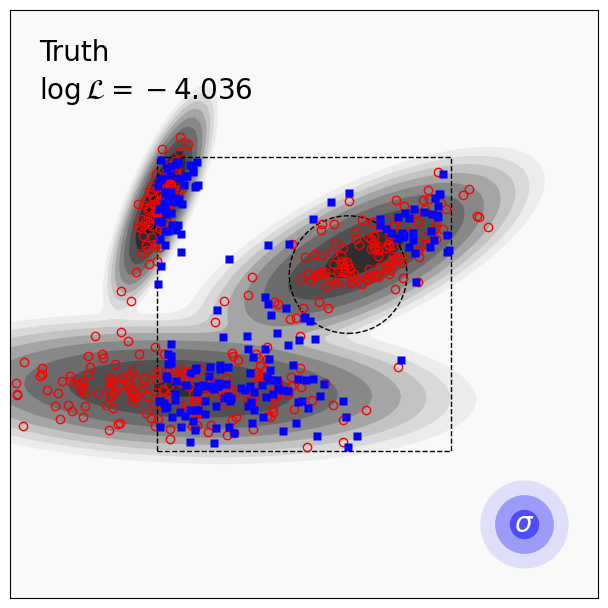

In [12]:

# plot data vs true model
plotResults(orig, data, gmm, patch=ps, description="Truth", disp=disp, log=False)


# EM without imputation, deconvolving via extreme convolution 

initializing spheres with s=3.20 near data points


ITER	SAMPLES	LOG_L	STABLE
0	199	-1395.559	0
1	199	-1072.425	3
2	199	-940.684	3
3	199	-873.870	3
4	199	-851.610	3
5	199	-839.873	3
6	199	-828.422	3
7	199	-817.344	3
8	199	-809.362	3
9	199	-805.982	3
10	199	-804.337	3
11	199	-803.254	3
12	199	-802.393	3
13	199	-801.637	3
likelihood converged within relative tolerance 0.001: stopping here.


execution time 4s


Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


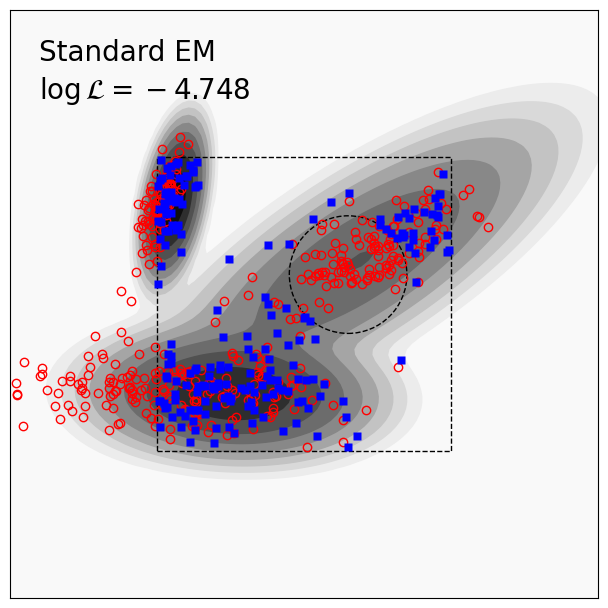

In [13]:
#
# repeated runs: store results and logL
l = np.empty(T)
gmms = [pygmmis.GMM(K=K, D=D) for r in range(T)]

# 1) EM without imputation, ignoring errors
start = datetime.datetime.now()
rng = RandomState(seed)
for r in range(T):
    if bg is not None:
        bg.amp = bg_amp
    l[r], _ = pygmmis.fit(gmms[r], data, w=w, cutoff=cutoff, background=bg, rng=rng)
avg = pygmmis.stack(gmms, l)
print ("execution time %ds" % (datetime.datetime.now() - start).seconds)
plotResults(orig, data, avg, patch=ps, description="Standard EM")

# pygmmis with imputation, igoring errors

initializing spheres with s=3.20 near data points
ITER	SAMPLES	LOG_L	STABLE
0	199	-1395.559	0
1	199	-1072.425	3
2	199	-940.684	3
3	199	-873.870	3
4	199	-851.610	3
5	199	-839.873	3
6	199	-828.422	3
7	199	-817.344	3
8	199	-809.362	3
9	199	-805.982	3
10	199	-804.337	3
11	199	-803.254	3
12	199	-802.393	3
13	199	-801.637	3
likelihood converged within relative tolerance 0.001: stopping here.
ITER	SAMPLES	IMPUTED	ORIG	LOG_L	STABLE
0	199	56.40	255.90	-751.287	3
1	199	83.90	279.80	-737.884	3
2	199	94.60	289.60	-738.142	3
3	199	112.10	309.60	-730.090	3
4	199	119.70	320.30	-730.285	3
5	199	122.20	320.30	-731.884	3
6	199	123.30	320.30	-732.336	3
7	199	126.20	327.70	-731.431	3
8	199	125.20	327.70	-732.800	3
9	199	131.30	327.70	-731.072	3
10	199	141.30	336.80	-727.418	3
11	199	137.70	336.80	-731.984	3
12	199	141.50	336.80	-728.608	3
13	199	138.30	336.80	-730.841	3
14	199	136.80	336.80	-731.522	3
15	199	133.50	328.30	-734.454	3
16	199	133.30	328.30	-733.395	3
17	199	143.80	342.20	-727.495	3
18	199	14

execution time 8s


Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


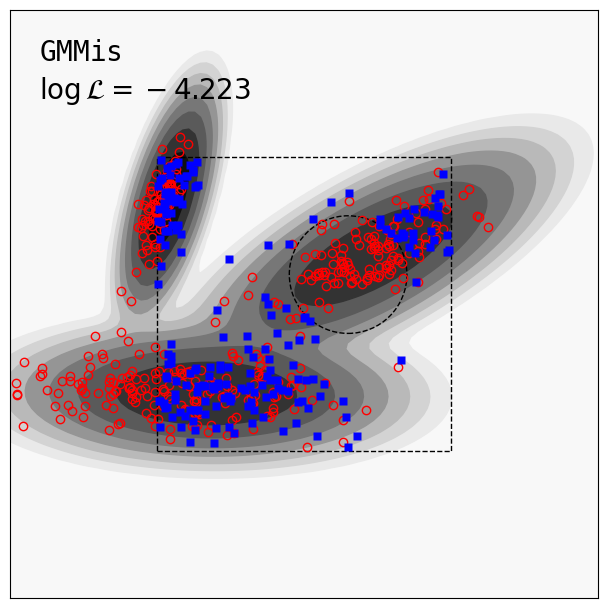

In [14]:
start = datetime.datetime.now()
rng = RandomState(seed)
for r in range(T):
    if bg is not None:
        bg.amp = bg_amp
    pygmmis.fit(gmms[r], data, w=w, cutoff=cutoff, background=bg, rng=rng)
    l[r], _ = pygmmis.fit(gmms[r], data, init_method='none', w=w,  cutoff=cutoff, sel_callback=omega,  oversampling=oversampling, background=bg, rng=rng)
avg = pygmmis.stack(gmms, l)
print ("execution time %ds" % (datetime.datetime.now() - start).seconds)
plotResults(orig, data, avg, patch=ps, description="$\mathtt{GMMis}$")


# 4) pygmmis with imputation, incorporating errors


initializing spheres with s=3.20 near data points
ITER	SAMPLES	LOG_L	STABLE
0	199	-1395.559	0
1	199	-1072.425	3
2	199	-940.684	3
3	199	-873.870	3
4	199	-851.610	3
5	199	-839.873	3
6	199	-828.422	3
7	199	-817.344	3
8	199	-809.362	3
9	199	-805.982	3
10	199	-804.337	3
11	199	-803.254	3
12	199	-802.393	3
13	199	-801.637	3
likelihood converged within relative tolerance 0.001: stopping here.
ITER	SAMPLES	IMPUTED	ORIG	LOG_L	STABLE
0	199	68.10	268.80	-755.794	3
1	199	99.00	300.90	-738.403	3
2	199	103.40	300.90	-741.085	3
3	199	111.90	309.40	-737.238	3
4	199	120.60	320.00	-734.711	3
5	199	122.70	320.00	-735.933	3
6	199	124.20	320.00	-736.374	3
7	199	130.00	333.20	-732.961	3
8	199	138.50	333.20	-730.252	3
9	199	131.90	333.20	-736.818	3
10	199	142.80	337.40	-729.542	3
11	199	139.00	337.40	-733.987	3
12	199	143.30	341.30	-730.637	3
13	199	143.80	341.30	-730.765	3
14	199	142.00	341.30	-732.006	3
15	199	144.80	341.30	-731.089	3
16	199	139.50	341.30	-735.084	3
17	199	145.40	341.30	-730.508	3
18	199	1

execution time 9s


Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


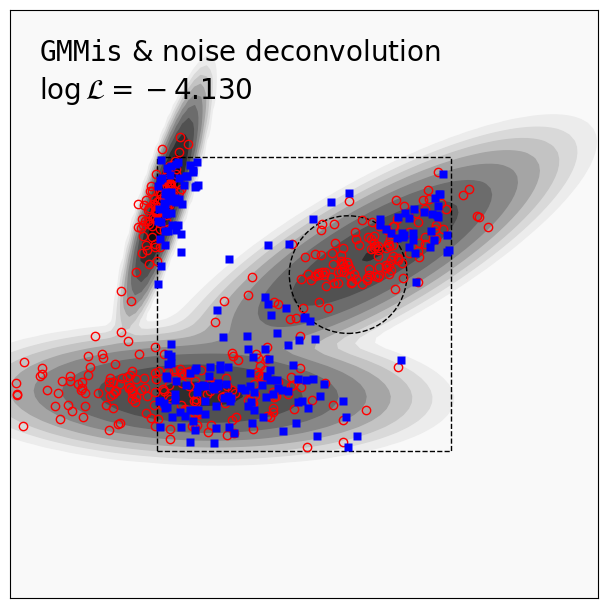

In [15]:

covar_cb = partial(pygmmis.covar_callback_default, default=np.eye(D)*disp**2)
start = datetime.datetime.now()
rng = RandomState(seed)
for r in range(T):
    if bg is not None:
        bg.amp = bg_amp
    pygmmis.fit(gmms[r], data, w=w, cutoff=cutoff, background=bg, rng=rng)
    l[r], _ = pygmmis.fit(gmms[r], data, covar=covar, init_method='none', w=w, cutoff=cutoff, sel_callback=omega, oversampling=oversampling, covar_callback=covar_cb, background=bg, rng=rng)
avg = pygmmis.stack(gmms, l)
print ("execution time %ds" % (datetime.datetime.now() - start).seconds)
plotResults(orig, data, avg, patch=ps, description="$\mathtt{GMMis}$ & noise deconvolution")

# SNL

### Data for SNL

In [16]:

batch_size_snl = 32
proposal_sample = batch_size_snl * 10
lr = 0.01
# n_epochs = 100
n_iter = 10000

config = {
    'n_iter': n_iter,
    'lr': lr,
    'proposal_sample': proposal_sample,
    'batch_size': batch_size_snl,
    'n_iter': n_iter,
    'seed': seed,
}


In [17]:
from Model.Energy import GeneralizedGaussianMixtureEnergy,GeneralizedGaussianMixtureEnergyVectorParam, CircleTruncation, CombineTruncation, MaxMinTruncation
from Model.Proposal import GaussianProposal, UniformProposal, MixtureOfGeneralizedGaussianProposal, MixtureOfGaussianProposal
from Data import get_dataloader_from_data
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from Model.Trainer import SNLTrainer
from Model.Energy import MaxMinCensorship
import random

In [18]:
train_dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(torch.tensor(orig, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)


In [19]:

# proposal_distribution = GaussianProposal(torch.Size([2,]), torch.tensor([0,0], dtype=torch.float32), torch.tensor([10,10], dtype=torch.float32))
# proposal_distribution.mu.data = torch.tensor([5,5], dtype=torch.float32)
# proposal_distribution.sigma.data = torch.tensor([7,7], dtype=torch.float32)
proposal_distribution = UniformProposal(torch.Size([2,]), torch.tensor([0,0], dtype=torch.float32), torch.tensor([10,10], dtype=torch.float32))


Init Standard Gaussian...


### Energy 

In [20]:
energy = GeneralizedGaussianMixtureEnergy(dim=2, num_cluster=3, learn_pi=True, learn_mu=True, learn_sigma=True)
energy = GeneralizedGaussianMixtureEnergyVectorParam(dim=2, num_cluster=3, learn_pi=True, learn_mu=True, learn_sigma=True)


In [21]:
# KMeans on Data :
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
centers = kmeans.cluster_centers_

energy.mu.data = torch.tensor(centers, dtype=torch.float32)

/opt/miniconda3/envs/lime_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
circle_truncation = CircleTruncation(center = torch.tensor([6.5, 6], dtype=torch.float32), radius=2)
maxmin_truncation = MaxMinTruncation(min = torch.tensor([0,0], dtype=torch.float32), max = torch.tensor([10,10], dtype=torch.float32))
combine_truncation = CombineTruncation([circle_truncation, maxmin_truncation])



/Users/hhjs/Documents/Projects/SNL_directional/Model/Energy/Truncation/abstract_truncation.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.max = torch.tensor(max, dtype=torch.float32)
/Users/hhjs/Documents/Projects/SNL_directional/Model/Energy/Truncation/abstract_truncation.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.min = torch.tensor(min, dtype=torch.float32)


In [23]:
energy.set_truncator(combine_truncation)

# Trainer

## Trainer Uniform

In [24]:
trainer = SNLTrainer(energy, proposal_distribution, dataloader=train_loader, val_dataloader=train_loader, n_sample_train=proposal_sample, n_sample_test=10000, lr=lr)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hugosenetaire. Use `wandb login --relogin` to force relogin


[[2.74114799 2.24324465]
 [0.72963417 8.42926502]
 [8.63901138 7.57745266]]


Substituting symbol L from STIXNonUnicode
/Users/hhjs/Documents/Projects/SNL_directional/test_pygmmis.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
Substituting symbol L from STIXNonUnicode


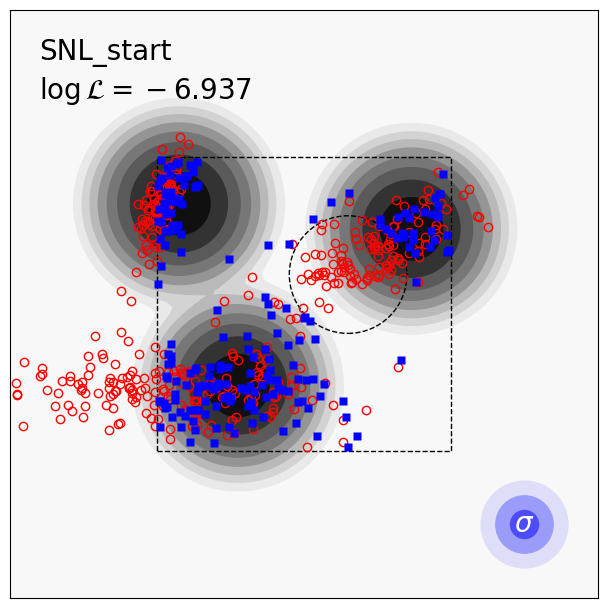

In [25]:
D = 2
gmm = pygmmis.GMM(K=3, D=2)
gmm.amp[:] = torch.nn.functional.log_softmax(energy.logit_pi, dim=-1).exp().detach().numpy()
gmm.amp /= gmm.amp.sum()
gmm.mean[:,:] = energy.mu.detach().numpy()
print(gmm.mean)
gmm.covar[:,:,:] = torch.linalg.inv(energy.get_precision_matrix()).detach().numpy()
# plot data vs true model
plotResults(orig, data, gmm, patch=ps, description="SNL_start", disp=disp, log=True, name="SNL_start", )


In [26]:
trainer.train(n_iter=n_iter, n_iter_pretrain=1000, plot_every=500)

/Users/hhjs/Documents/Projects/SNL_directional/Model/Energy/generalized_gaussian_mixture_vector_param.py:101: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.log_softmax(self.logit_pi) - energy_per_cluster, dim=-1


KeyboardInterrupt: 

Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


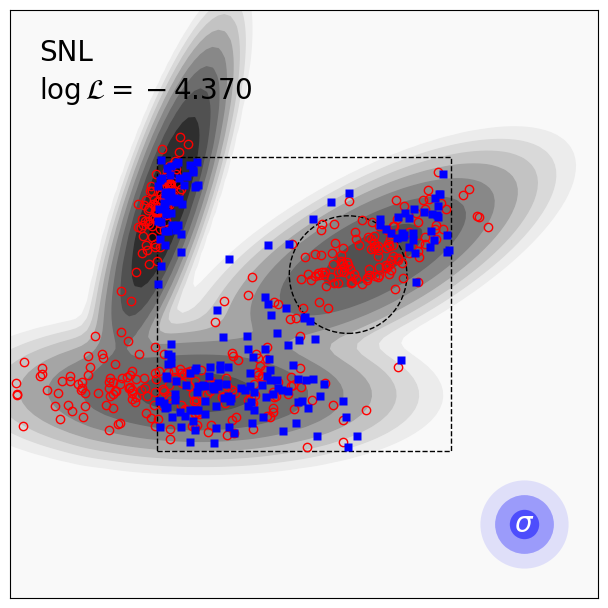

In [27]:
D = 2
gmm = pygmmis.GMM(K=3, D=2)
gmm.amp[:] = torch.nn.functional.log_softmax(energy.logit_pi, dim=-1).exp().detach().numpy()
gmm.amp /= gmm.amp.sum()
gmm.mean[:,:] = energy.mu.detach().numpy()
gmm.covar[:,:,:] = torch.linalg.inv(energy.get_precision_matrix()).detach().numpy()
# plot data vs true model
# plotResults(orig[:1], data[:1], gmm, patch=ps, description="SNL", disp=disp)
plotResults(orig, data, gmm, patch=ps, description="SNL", disp=disp, log=True, name="SNL Best", step =trainer.total_step)

### Load best

Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


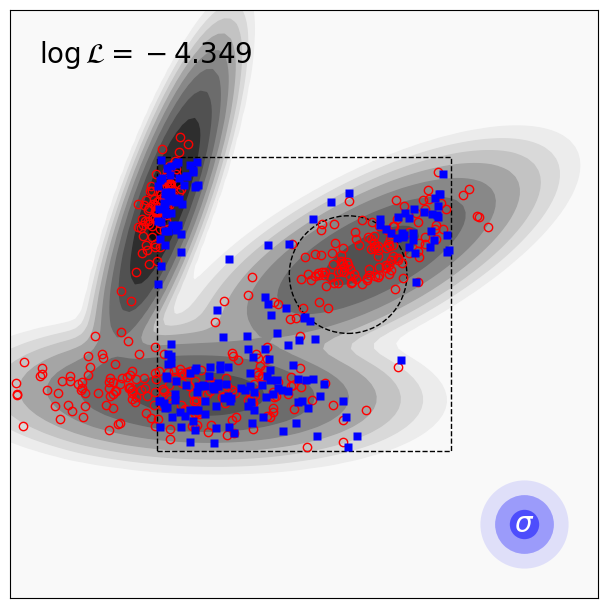

In [28]:
trainer.get_best_model()
best_energy = trainer.best_energy
D = 2
gmm = pygmmis.GMM(K=3, D=2)
gmm.amp[:] = torch.nn.functional.log_softmax(best_energy.logit_pi, dim=-1).exp().detach().numpy()
gmm.amp /= gmm.amp.sum()
gmm.mean[:,:] = best_energy.mu.detach().numpy()
gmm.covar[:,:,:] = torch.linalg.inv(best_energy.get_precision_matrix()).detach().numpy()
# plot data vs true model
# plotResults(orig[:1], data[:1], gmm, patch=ps, description="SNL", disp=disp)
plotResults(orig, data, gmm, patch=ps, disp = disp, log=True, name="SNL Uniform", step=trainer.best_step)

## Trainer Mixture

In [29]:
logit = torch.nn.functional.log_softmax(energy.logit_pi, dim=-1).exp().detach()
mean = energy.mu.detach()
covar = torch.linalg.inv(energy.get_precision_matrix()).detach()
proposal_v2 = MixtureOfGeneralizedGaussianProposal(input_size = torch.Size((2,)), logit_pi = logit, mu = mean, sigma = covar)
trainer.proposal = proposal_v2

Init Standard Gaussian...


In [30]:
trainer.train(n_iter=n_iter, n_iter_pretrain=0, plot_every=500)

KeyboardInterrupt: 

Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


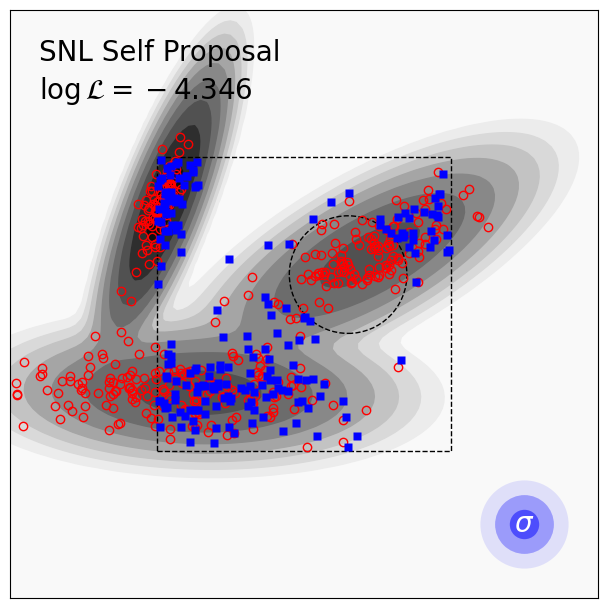

In [31]:
D = 2
gmm = pygmmis.GMM(K=3, D=2)
gmm.amp[:] = torch.nn.functional.log_softmax(energy.logit_pi, dim=-1).exp().detach().numpy()
gmm.amp /= gmm.amp.sum()
gmm.mean[:,:] = energy.mu.detach().numpy()
gmm.covar[:,:,:] = torch.linalg.inv(energy.get_precision_matrix()).detach().numpy()
# plot data vs true model
# plotResults(orig[:1], data[:1], gmm, patch=ps, description="SNL", disp=disp)
plotResults(orig, data, gmm, patch=ps, description="SNL Self Proposal", disp=disp, log=True, name="SNL_self_proposal", step =trainer.total_step)

### Load best

Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


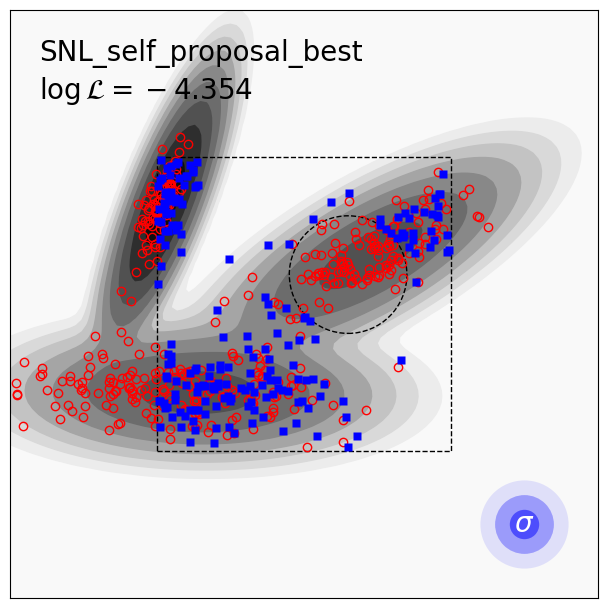

In [32]:
trainer.get_best_model()
best_energy = trainer.best_energy
D = 2
gmm = pygmmis.GMM(K=3, D=2)
gmm.amp[:] = torch.nn.functional.log_softmax(best_energy.logit_pi, dim=-1).exp().detach().numpy()
gmm.amp /= gmm.amp.sum()
gmm.mean[:,:] = best_energy.mu.detach().numpy()
gmm.covar[:,:,:] = torch.linalg.inv(best_energy.get_precision_matrix()).detach().numpy()
# plot data vs true model
# plotResults(orig[:1], data[:1], gmm, patch=ps, description="SNL", disp=disp)
plotResults(orig, data, gmm, patch=ps, log=True, description="SNL_self_proposal_best", disp=disp, step = trainer.best_step)